In [1]:
!pip install ultralytics
!pip install deep_sort_realtime
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
model = YOLO('yolov8n.pt')

tracker = DeepSort(max_age=30)

100%|██████████| 6.25M/6.25M [00:00<00:00, 69.8MB/s]


In [6]:
def run_deepsort_tracking(dataset_path, sequence_name):
    image_files = sorted([os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.jpg')])

    print(f"Total {len(image_files)} frames found in the sequence.")

    tracking_results = []
    frame_count = 0
    start_time = time.time()

    for idx, img_path in enumerate(image_files):
        frame = cv2.imread(img_path)
        frame_count += 1

        # YOLOv8 detection
        results = model.predict(frame, imgsz=640, conf=0.5)[0]
        detections = results.boxes.xyxy.cpu().numpy()
        confidences = results.boxes.conf.cpu().numpy()
        class_ids = results.boxes.cls.cpu().numpy()

        # Prepare detections for DeepSORT
        dets = []
        for det, conf, cls in zip(detections, confidences, class_ids):
            x1, y1, x2, y2 = det
            dets.append(([x1, y1, x2 - x1, y2 - y1], conf, 'person'))

        # Update tracker
        tracks = tracker.update_tracks(dets, frame=frame)

        # Draw tracks
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, f'ID: {track_id}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            tracking_results.append([idx + 1, track_id, x1, y1, x2 - x1, y2 - y1])

        # Display frame
        if idx % 200 == 0:

            resized_frame = cv2.resize(frame, (640, 360))
            cv2_imshow(resized_frame)

    end_time = time.time()
    fps = frame_count / (end_time - start_time)
    print(f"Processed {frame_count} frames in {end_time - start_time:.2f} seconds. FPS: {fps:.2f}")

    # Save tracking results
    tracking_results = np.array(tracking_results, dtype=int)
    output_path = f'/content/sort_tracking_{sequence_name}.txt'
    np.savetxt(output_path, tracking_results, fmt='%d', delimiter=',')

    return tracking_results, fps

In [7]:
dataset_path1 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-02-SDP/img1/'
dataset_path2 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-04-FRCNN/img1/'
dataset_path3 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-09-DPM/img1/'
dataset_path4 = '/content/drive/MyDrive/CMP719/MOT17/MOT17-10-SDP/img1/'

Total 600 frames found in the sequence.

0: 384x640 5 persons, 137.1ms
Speed: 5.5ms preprocess, 137.1ms inference, 19.4ms postprocess per image at shape (1, 3, 384, 640)


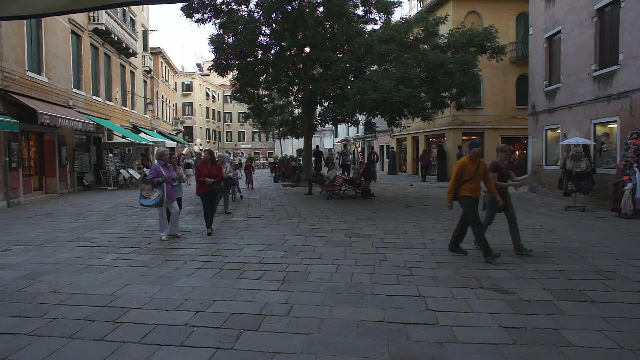


0: 384x640 5 persons, 89.2ms
Speed: 2.3ms preprocess, 89.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 92.1ms
Speed: 2.2ms preprocess, 92.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 102.1ms
Speed: 2.3ms preprocess, 102.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 88.5ms
Speed: 2.3ms preprocess, 88.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 95.0ms
Speed: 2.2ms preprocess, 95.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 286.9ms
Speed: 5.9ms preprocess, 286.9ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 102.8ms
Speed: 3.0ms preprocess, 102.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 97.5ms
Speed: 2.6ms preprocess, 97.5ms inference, 0.7ms postprocess per

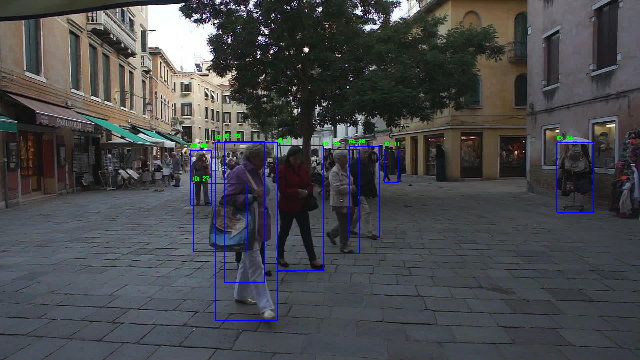


0: 384x640 5 persons, 120.4ms
Speed: 2.4ms preprocess, 120.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 107.6ms
Speed: 2.7ms preprocess, 107.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.1ms
Speed: 2.4ms preprocess, 103.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 111.9ms
Speed: 2.2ms preprocess, 111.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 108.4ms
Speed: 2.6ms preprocess, 108.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 102.5ms
Speed: 2.4ms preprocess, 102.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 103.1ms
Speed: 2.3ms preprocess, 103.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 126.9ms
Speed: 2.4ms preprocess, 126.9ms inference, 0.8ms postprocess per 

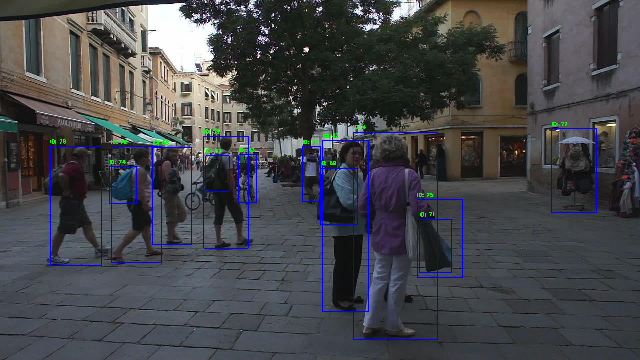


0: 384x640 7 persons, 109.7ms
Speed: 3.6ms preprocess, 109.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 151.7ms
Speed: 2.3ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 147.8ms
Speed: 2.3ms preprocess, 147.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 backpack, 147.6ms
Speed: 7.1ms preprocess, 147.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 147.8ms
Speed: 2.2ms preprocess, 147.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 114.9ms
Speed: 2.0ms preprocess, 114.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 110.7ms
Speed: 4.2ms preprocess, 110.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 116.9ms
Speed: 2.3ms preprocess, 116.9ms

In [8]:
tracking_results1, fps1 = run_deepsort_tracking(dataset_path1, "MOT17-02-SDP" )

In [9]:
tracking_results2, fps2 = run_deepsort_tracking(dataset_path2, "MOT17-04-FRCNN" )

Output hidden; open in https://colab.research.google.com to view.

Total 525 frames found in the sequence.

0: 384x640 6 persons, 101.6ms
Speed: 3.1ms preprocess, 101.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


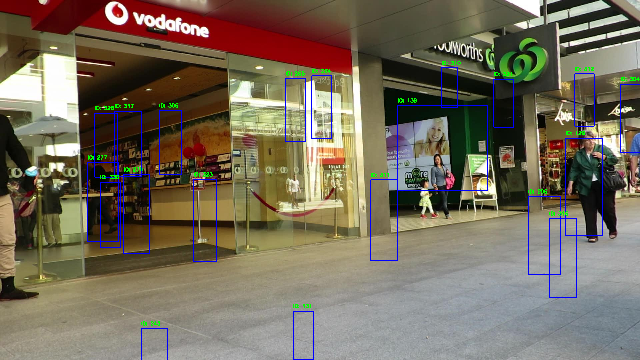


0: 384x640 8 persons, 96.0ms
Speed: 2.6ms preprocess, 96.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 96.4ms
Speed: 3.8ms preprocess, 96.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 110.6ms
Speed: 4.3ms preprocess, 110.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 126.2ms
Speed: 2.6ms preprocess, 126.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 216.8ms
Speed: 4.9ms preprocess, 216.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 161.4ms
Speed: 9.2ms preprocess, 161.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 207.5ms
Speed: 2.9ms preprocess, 207.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 156.7ms
Speed: 3.4ms preprocess, 156.7ms inference, 0.9ms postproce

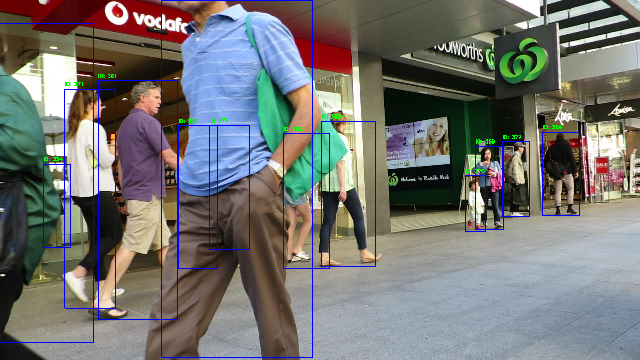


0: 384x640 10 persons, 123.5ms
Speed: 2.9ms preprocess, 123.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 115.8ms
Speed: 2.4ms preprocess, 115.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 117.9ms
Speed: 3.0ms preprocess, 117.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 112.8ms
Speed: 5.0ms preprocess, 112.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 116.2ms
Speed: 3.3ms preprocess, 116.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 155.6ms
Speed: 2.4ms preprocess, 155.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 tv, 172.8ms
Speed: 6.3ms preprocess, 172.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 tv, 162.4ms
Speed: 2.7ms preprocess, 162.4ms inferen

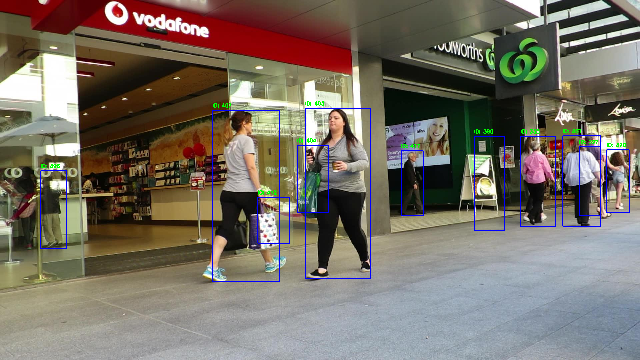


0: 384x640 6 persons, 125.2ms
Speed: 10.4ms preprocess, 125.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 handbag, 118.8ms
Speed: 2.6ms preprocess, 118.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 handbag, 116.3ms
Speed: 2.3ms preprocess, 116.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 109.2ms
Speed: 2.3ms preprocess, 109.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 121.7ms
Speed: 2.4ms preprocess, 121.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 163.0ms
Speed: 4.4ms preprocess, 163.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2 handbags, 156.0ms
Speed: 2.7ms preprocess, 156.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 handbag, 140.6ms
Speed: 2.

In [10]:
tracking_results3, fps3 = run_deepsort_tracking(dataset_path3, "MOT17-09-DPM" )

Total 654 frames found in the sequence.

0: 384x640 7 persons, 1 truck, 98.3ms
Speed: 2.8ms preprocess, 98.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


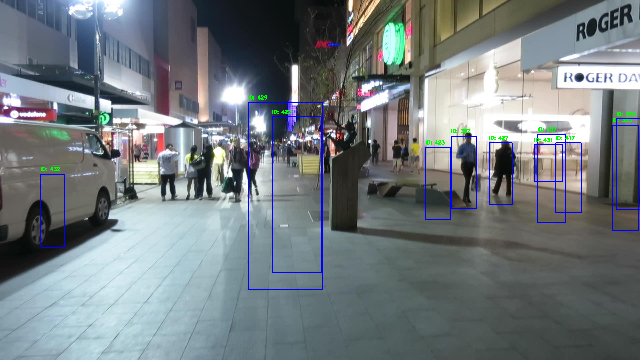


0: 384x640 6 persons, 96.9ms
Speed: 2.9ms preprocess, 96.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 truck, 96.1ms
Speed: 3.2ms preprocess, 96.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 100.4ms
Speed: 2.7ms preprocess, 100.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 101.2ms
Speed: 3.1ms preprocess, 101.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 99.5ms
Speed: 3.1ms preprocess, 99.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 270.0ms
Speed: 5.7ms preprocess, 270.0ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 truck, 158.1ms
Speed: 2.8ms preprocess, 158.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 truck, 140.3ms
Speed: 5.9ms preprocess, 1

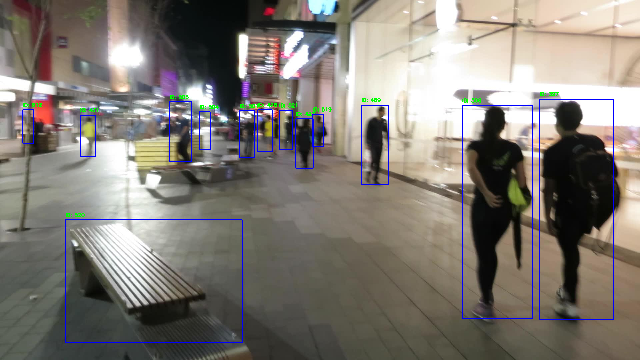


0: 384x640 4 persons, 1 bench, 1 backpack, 170.8ms
Speed: 2.7ms preprocess, 170.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 1 backpack, 168.7ms
Speed: 2.4ms preprocess, 168.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 1 backpack, 214.9ms
Speed: 7.3ms preprocess, 214.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1 bench, 112.0ms
Speed: 2.6ms preprocess, 112.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 bench, 110.7ms
Speed: 2.4ms preprocess, 110.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 113.5ms
Speed: 2.6ms preprocess, 113.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bench, 108.5ms
Speed: 2.5ms preprocess, 108.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640

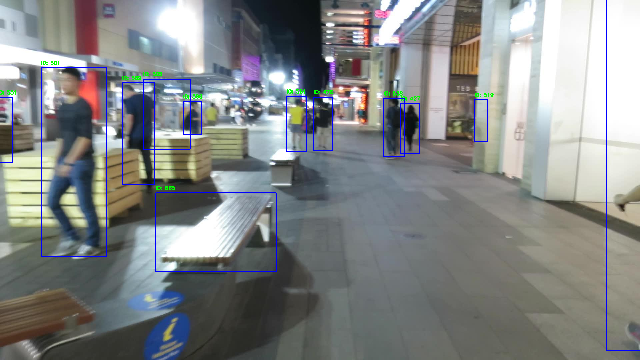


0: 384x640 8 persons, 1 bench, 161.0ms
Speed: 4.7ms preprocess, 161.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 129.6ms
Speed: 2.3ms preprocess, 129.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 130.7ms
Speed: 2.6ms preprocess, 130.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 109.9ms
Speed: 2.5ms preprocess, 109.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 110.3ms
Speed: 3.2ms preprocess, 110.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 123.2ms
Speed: 2.3ms preprocess, 123.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 115.3ms
Speed: 2.4ms preprocess, 115.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bench, 112.5ms
Speed: 4.1ms preproce

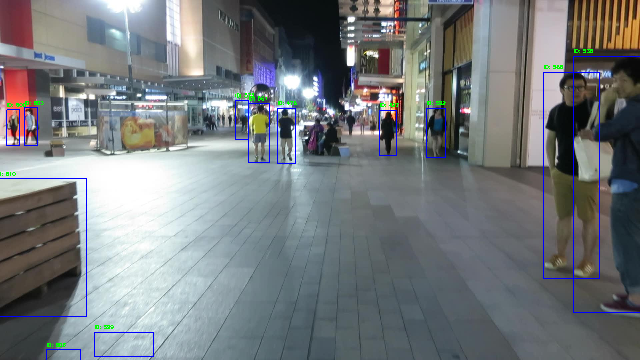


0: 384x640 8 persons, 1 bench, 215.8ms
Speed: 6.6ms preprocess, 215.8ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 201.2ms
Speed: 2.8ms preprocess, 201.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 189.2ms
Speed: 2.5ms preprocess, 189.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 121.2ms
Speed: 2.6ms preprocess, 121.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1 bench, 125.3ms
Speed: 5.6ms preprocess, 125.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 128.3ms
Speed: 4.4ms preprocess, 128.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 bench, 133.1ms
Speed: 5.6ms preprocess, 133.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 127.9ms
Spe

In [11]:
tracking_results4, fps4 = run_deepsort_tracking(dataset_path4, "MOT17-10-SDP" )

In [12]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [13]:
def compute_mota_motp(sequence_name, tracking_results):
    print(f"Results for {sequence_name}:\n")
    gt_path = f'/content/drive/MyDrive/CMP719/MOT17/{sequence_name}/gt/gt.txt'
    # Load ground truth
    gt = pd.read_csv(gt_path, header=None)
    gt.columns = ["frame", "id", "x", "y", "w", "h", "conf", "class", "vis"]
    gt = gt[gt['conf'] == 1]
    gt = gt[["frame", "id", "x", "y", "w", "h"]]

    # Convert tracking results to DataFrame
    trk = pd.DataFrame(tracking_results, columns=["frame", "id", "x", "y", "w", "h"])

    total_gt = len(gt)
    matches = 0
    total_iou = 0
    id_switches = 0
    prev_ids = {}

    for frame in sorted(gt['frame'].unique()):
        gt_frame = gt[gt['frame'] == frame]
        trk_frame = trk[trk['frame'] == frame]

        gt_boxes = gt_frame[['x', 'y', 'w', 'h']].values
        trk_boxes = trk_frame[['x', 'y', 'w', 'h']].values

        if len(gt_boxes) == 0 or len(trk_boxes) == 0:
            continue

        ious = np.zeros((len(gt_boxes), len(trk_boxes)))
        for i, gt_box in enumerate(gt_boxes):
            for j, trk_box in enumerate(trk_boxes):
                ious[i, j] = compute_iou(gt_box, trk_box)

        matched_indices = np.argwhere(ious > 0.5)
        matches += len(matched_indices)
        total_iou += ious[matched_indices[:, 0], matched_indices[:, 1]].sum()

        # ID switch calculation
        for m in matched_indices:
            gt_id = gt_frame.iloc[m[0]]['id']
            trk_id = trk_frame.iloc[m[1]]['id']
            if gt_id in prev_ids and prev_ids[gt_id] != trk_id:
                id_switches += 1
            prev_ids[gt_id] = trk_id

    mota = matches / total_gt if total_gt > 0 else 0
    motp = total_iou / matches if matches > 0 else 0

    print(f"MOTA: {mota:.4f}")
    print(f"MOTP: {motp:.4f}")
    print(f"ID Switches: {id_switches}")

In [14]:
compute_mota_motp("MOT17-02-SDP", tracking_results1)

compute_mota_motp("MOT17-04-FRCNN", tracking_results2)

compute_mota_motp("MOT17-09-DPM", tracking_results3)

compute_mota_motp("MOT17-10-SDP", tracking_results4)

Results for MOT17-02-SDP:

MOTA: 0.2348
MOTP: 0.7974
ID Switches: 228
Results for MOT17-04-FRCNN:

MOTA: 0.3625
MOTP: 0.8336
ID Switches: 611
Results for MOT17-09-DPM:

MOTA: 0.8700
MOTP: 0.7821
ID Switches: 680
Results for MOT17-10-SDP:

MOTA: 0.4127
MOTP: 0.7773
ID Switches: 226
